## Clustering Morphologies Using [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis)

The distance metric is a p-norm between persistence landscapes generated from sub-level set filtrations over neuronal trees. See [Kanari, L., Dłotko, P., Scolamiero, M. et al. A Topological Representation of Branching Neuronal Morphologies. Neuroinform 16, 3–13 (2018)](https://link.springer.com/article/10.1007/s12021-017-9341-1) for the filtration approach.

For a primer on persistence landscapes, see [Bubenik, P.. (2015). Statistical topological data analysis using persistence landscapes. Journal of Machine Learning Research. 16. 77-102. ](http://jmlr.org/papers/v16/bubenik15a.html)

As usual, we 1) initialize Fiji with GUI support (see [Overview](1_overview.ipynb) for details on how to link your local Fiji installation to this notebook); 2) import all relevant python modules; and 3) import all relevant SNT classes:

In [1]:
import ijfinder
import imagej
import os

fiji_path = ijfinder.getpath().decode('utf-8')
if os.path.isdir(fiji_path):
    ij = imagej.init(fiji_path, headless=False)
else:
    print("Cannot proceed: Fiji not found!")

In [2]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, ward

In [3]:
from jnius import autoclass, cast
Tree = autoclass('sc.fiji.snt.Tree')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
PersistenceAnalyzer = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')
Viewer3D = autoclass('sc.fiji.snt.viewer.Viewer3D')
ColorTables = autoclass('net.imagej.display.ColorTables')

In [4]:
tree_map = {}     # global
labels = []       # global

In [5]:
def fetch_reconstructions():
    """
    Two types of mouse neuron from MOs with differing projection patterns descbried in 
    Winnubst et al. Cell 2019
    Group 0 contains the Layer 5 Medulla projecting PT type. 
    Group 1 contains the Layer 6 Corticothalamic type.
    pre print at https://www.biorxiv.org/content/biorxiv/early/2017/12/05/229260.full.pdf
    """
    group_0 = ['AA0011', 'AA0012', 'AA0115', 'AA0179', 'AA0180', 'AA0181', 'AA0182', 'AA0245', 
              'AA0250', 'AA0576', 'AA0726', 'AA0788', 'AA0791', 'AA0792']
    group_1 = ['AA0039', 'AA0101', 'AA0103', 'AA0105', 'AA0188', 'AA0278', 'AA0390', 'AA0394', 
              'AA0406', 'AA0577', 'AA0599', 'AA0633', 'AA0650', 'AA0781', 'AA0784', 'AA0799', 
              'AA0817', 'AA0837', 'AA0838', 'AA0844']
    groups = [group_0, group_1]
    tree_list = []
    for num, group in enumerate(groups):
        for cell in group:
            loader = MouseLightLoader(cell)
            if not loader.isDatabaseAvailable(): 
                print("Database not available. Exiting...")
                return
            if not loader.idExists(): 
                print("Id not found in database. Exiting...")
                return
            # Only compare axon topologies
            tree = loader.getTree('axon')
            tree_list.append(tree)
            tree_map[tree.getLabel()[0:6]] = tree
            tree.setLabel(tree.getLabel() + ' group: ' + str(num))
            labels.append(tree.getLabel())
            
    return tree_list
    
    
def compute_distance_matrix(trees):
    landscapes = []
    for tree in trees:  
        """
        Obtain the Persistence Landscape as a N-dimensional vector,
        where N == resolution x number of landscapes.
        We use the geodesic distance descriptor function, 100 resolution and 5 landscapes.
        The returned data type is a Java Array, so we must convert it to the equivalent
        Python representation by using the ij.py.from_java() method.
        """
        ls = ij.py.from_java(PersistenceAnalyzer(tree).getLandscape('geodesic', 100, 5))
        landscapes.append(ls)

    t0 = time.time()
    # The Chebyshev distance between persistence landscapes is stable with respect to 
    # the bottleneck distance between persistence diagrams.
    distance_matrix = pairwise_distances(landscapes, metric='chebyshev')
    t1 = time.time()
    print(t1-t0, ' seconds to compute all distances')

    return distance_matrix

In [6]:
tree_list = fetch_reconstructions()

In [7]:
distance_matrix = compute_distance_matrix(tree_list)

0.0020017623901367188  seconds to compute all distances


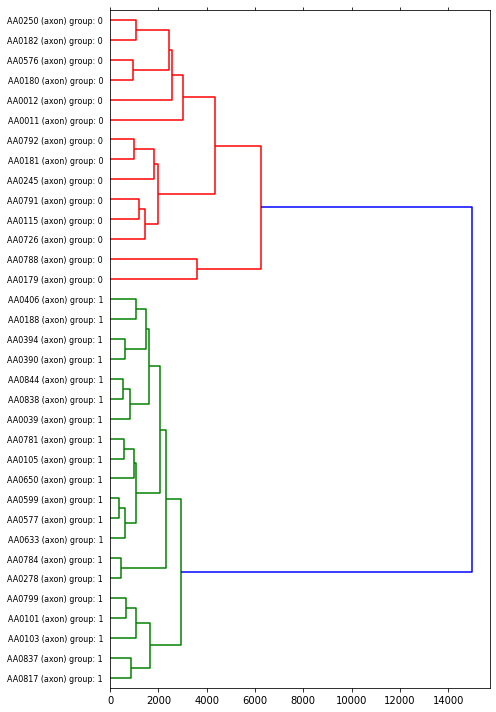

In [8]:
# Perform Hierarchical Clustering on the bottleneck distance matrix and plot a dendrogram
# of the resulting linkage matrix.

# Convert to n-choose-2 dimensional vector to pass to linkage function
mat_arr = squareform(distance_matrix)

linkage_matrix = ward(mat_arr) #define linkage_matrix using Ward's method

fig, ax = plt.subplots(figsize=(7, 10)) # set size
dendrogram(linkage_matrix, orientation='right', labels=labels) 
plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tight_layout()
plt.savefig('./images/ward_clusters.png', dpi=300)

Lets plot the two neighboring cells in each family

In [9]:
def get_group_viewers(compare):
    viewers = []
    for pair in compare:
        true_labels = []
        v = Viewer3D()
        v.loadRefBrain('mouse')
        v.setViewMode('sagittal')
        for t in pair:
            v.addTree(tree_map[t])
            true_labels.append(tree_map[t].getLabel())
            
        v.colorCode(ij.py.to_java(true_labels), 'length', ColorTables.ICE)
        viewers.append(v)
        
    return viewers

In [10]:
compare = [['AA0576', 'AA0012'], ['AA0784', 'AA0278']]
viewers = get_group_viewers(compare)  

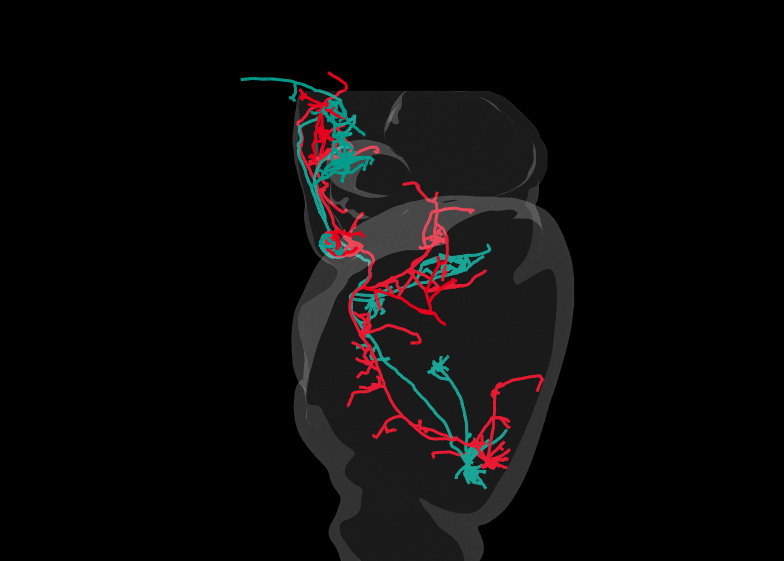

In [12]:
viewers[0].show()

# To embed the snapshot in this notebook
# from IPython.display import Image, display
# snapshot_path = os.getcwd() + '/images/group0exemplars.png'
# viewers[0].saveSnapshot(snapshot_path)
# display(Image(filename=snapshot_path))

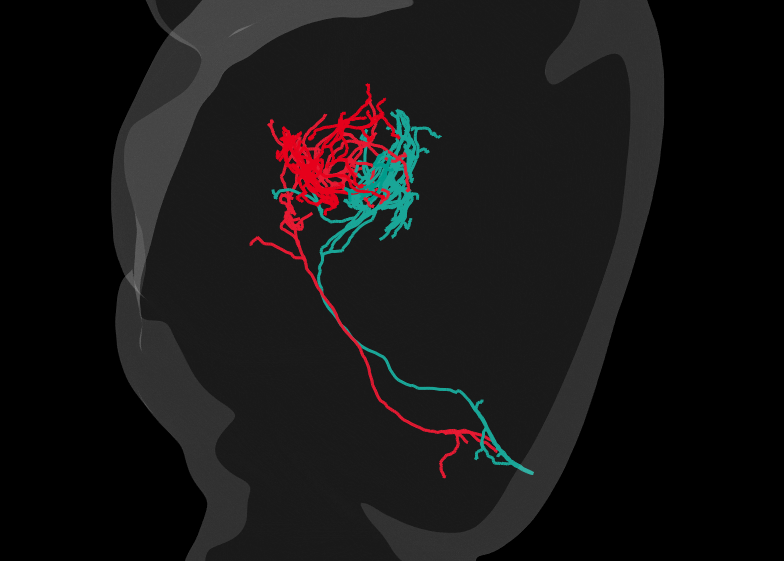

In [13]:
viewers[1].show()

# To embed the snapshot in this notebook
# snapshot_path = os.getcwd() + '/images/group1exemplars.png'
# viewers[1].saveSnapshot(snapshot_path)
# display(Image(filename=snapshot_path))